# Adversarial examples with MNIST

In this notebook, we'll:

* train a neural net on MNIST
* export the trained model (graph *and* weights)
* generate adversarial examples using the Fast Gradient Sign Method (and the targeted variant)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm, tqdm_gui

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

## Load the dataset

You've seen this before

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


## Build the model

In [5]:
def build_model(learnrate=0.01):
    """
    Wrapper function to build an MNIST classifier
    """
    x = tf.placeholder(tf.float32, [None, 784], name="x")
    y_ = tf.placeholder(tf.int32, [None,], name="y_")
    y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

    hidden = tf.layers.dense(x, 100, activation=tf.nn.tanh)
    output = tf.layers.dense(hidden, 10, name="output")
    logits = tf.identity(output, name="logits")
    y = tf.nn.softmax(logits, name="y")
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_oh, name="crossent")
    optimizer = tf.train.GradientDescentOptimizer(learnrate)
    train_step = optimizer.minimize(cross_entropy)
    
    prediction = tf.argmax(y,1)
    correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return x, y_, y, train_step, accuracy

In [6]:
tf.reset_default_graph()

In [7]:
x, y_, y, train_step, accuracy = build_model()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Train the model

In [8]:
def train_and_save(images, labels, logdir, epochs=100, batchsize=100):
    """
    Macro to split data into batches, run a training loop, and save the model.
    Automagically evaluates on MNIST test set.
    
    Returns test accuracy evaluated at the end of each epoch
    """
    # start a SavedModelBuilder to save everything out
    builder = tf.saved_model.builder.SavedModelBuilder(logdir)
    # find the number of batches to use
    num_batches = int(len(labels)/batchsize)

    # create an empty array to hold test accuracy at each step
    test_acc = np.zeros(epochs*num_batches)
    j=0
    progress_bar = tqdm(total=epochs*num_batches)
    # create a session to run in
    with tf.Session() as sess:
        # initialize variables
        sess.run(tf.global_variables_initializer())
        # for each training step
        for i in range(epochs):
            # shuffle and split into batches
            ordering = np.random.choice(np.arange(len(labels)), size=len(labels), replace=False)
            batches = list(zip(
                np.array_split(images[ordering,:], num_batches, axis=0),
                np.array_split(labels[ordering], num_batches)
            ))
            # for each batch of images and labels
            for (batch_xs, batch_ys) in batches:
                # feed them to the training operation
                fd = {x:batch_xs, y_:batch_ys}
                sess.run(train_step, feed_dict=fd)
        
                # now that we've updated the model weights, let's
                # compute the test accuracy
                test_acc[j] = sess.run(accuracy, feed_dict={x:mnist.test.images, 
                                                y_:mnist.test.labels})
                j += 1
                progress_bar.update()

        # export the model
        signature_def_map = {"model":tf.saved_model.signature_def_utils.predict_signature_def(
            inputs={"x":x},
            outputs={"y":y}
        )}
        builder.add_meta_graph_and_variables(sess, 
                                         ["tag"],
                                        signature_def_map=signature_def_map)
        builder.save()
    
    print("Final accuracy: %s"%round(test_acc[-1],3))
    progress_bar.close()
    return test_acc

In [9]:
test_acc = train_and_save(mnist.train.images, mnist.train.labels, "logs2/", epochs=2)

100%|█████████▉| 1099/1100 [01:01<00:00, 17.80it/s]

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'logs2/saved_model.pb'


100%|██████████| 1100/1100 [01:02<00:00, 17.74it/s]

Final accuracy: 0.961


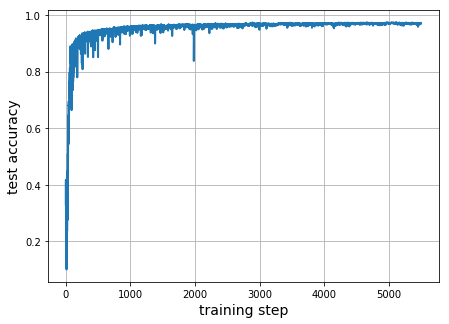

In [11]:
figsize(7,5)
plt.plot(test_acc, lw=2)
plt.xlabel("training step", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.grid("on");

In [11]:
tf.reset_default_graph()

In [12]:
def fgsm(logdir, x_adv, label, epsilon=0.01, num_iterations=1, targeted=False):
    """
    Use the Fast Gradient Sign Method to build adversarial examples
    
    :logdir: directory where the saved TF model is stored. Expects to find "x", "y_", 
            and "logits" tensors
    :x_adv: (N, 784) array of data points to build examples from
    :label: (N,) array of corresponding correct labels (if targeted=False) or
            target labels (if targeted=True)
    :epsilon: step size for shifting the examples
    :num_iterations: how many times to update the examples
    :targeted: whether to use targeted fast gradient
    
    Returns
    :x_adv: (N, 784) array of adversarial examples
    :probs: (N, C) array of softmax probabilities
    """
    x_adv = x_adv.copy()
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        # Load the saved network
        tf.saved_model.loader.load(sess, ["tag"], logdir)
        # Pull out tensors for the inputs
        x = graph.get_tensor_by_name("x:0")# the ":0" indexes the operation's output tensor
        y_ = graph.get_tensor_by_name("y_:0")
        # Pull out tensors for the logits
        logits = graph.get_tensor_by_name("logits:0")
        # compute outputs 
        y = tf.nn.softmax(logits)
    
        # build a loss function
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, 
                                                   labels=tf.one_hot(y_, 10))
        # find derivative of loss with respect to x
        dy_dx = tf.gradients(loss, x)[0]
        
        if targeted:
            epsilon *= -1
    
        # for each iteration
        for i in range(num_iterations):
            # compute the derivative with respect to the loss
            d = sess.run(dy_dx, {x:x_adv, y_:label})
            # save the new image by shifting the old one by epsilon * sign(gradient)
            x_adv += epsilon * np.sign(d)
        # compute softmax outputs for the examples
        probs = sess.run(y, {x:x_adv})
    return x_adv, probs

In [13]:
#let's test this out
adv_ind = 2
example = [mnist.test.images[adv_ind,:].reshape(1,-1)]
adv_label = mnist.test.labels[adv_ind].reshape(-1)
target_label = np.array([4])

# pick a few things to record
correct_label_prob = [] # softmax probability on the right answer
highest_wrong_prob = [] # largest softmax prob on a wrong answer
l2_distance = [] # mean L2 distance between adversarial and original
argmax = [] # assessed digit by the classifier

# let's manually loop through so we can see every step
for i in range(16):
    ex, probs = fgsm("logs2/", example[-1], adv_label)
    #ex, probs = fgsm("logs2/", example[-1], target_label, targeted=True)
    example.append(ex)
    correct_label_prob.append(probs[0,adv_label])
    highest_wrong_prob.append(np.max([probs[0,j] for j in range(10) if j != adv_label]))
    argmax.append(probs[0,:].argmax())
    l2_distance.append(np.sqrt(np.mean((example[-1]-example[0])**2)))

INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:tensorflow:Restoring parameters from b'logs2/variables/variables'
INFO:t

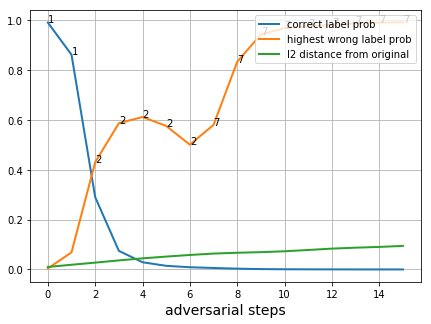

In [14]:
figsize(7,5)
plt.plot(correct_label_prob, label="correct label prob", lw=2)
plt.plot(highest_wrong_prob, label="highest wrong label prob", lw=2)
plt.plot(l2_distance, label="l2 distance from original", lw=2)
for i in range(len(correct_label_prob)):
    plt.text(i, max(highest_wrong_prob[i], correct_label_prob[i]), str(argmax[i]))
plt.legend(loc="upper right")
plt.xlabel("adversarial steps", fontsize=14)
plt.grid("on");

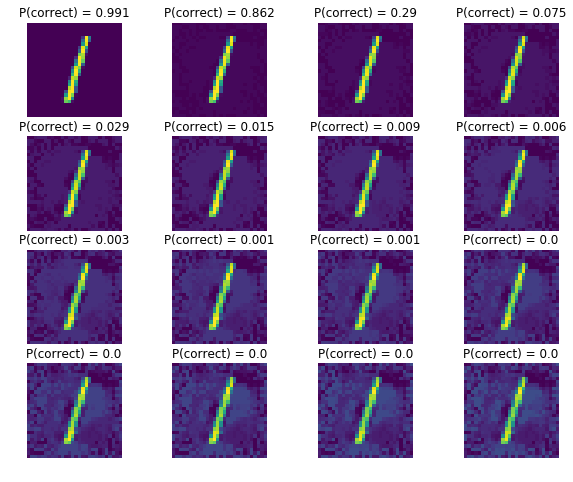

In [15]:
figsize(10,8)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(example[i].reshape((28,28)))
    plt.title("P(correct) = %s"%round(correct_label_prob[i][0], 3))
    plt.axis("off");